In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from collections import Counter

In [6]:
import matplotlib.pyplot as plt

In [39]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image

# **Getting Data**

In [2]:
ds_path = Path('../input/flowers/flowers').resolve()

In [37]:
paths = list(ds_path.glob('*/*'))
classes = [path.parent.stem for path in paths]

Counter(classes), len(classes), len(set(classes))

(Counter({'astilbe': 737,
          'daffodil': 970,
          'black_eyed_susan': 1000,
          'bellflower': 873,
          'common_daisy': 980,
          'coreopsis': 1047,
          'dandelion': 1052,
          'water_lily': 982,
          'carnation': 923,
          'calendula': 978,
          'california_poppy': 1022,
          'sunflower': 1027,
          'tulip': 1048,
          'rose': 999,
          'magnolia': 1048,
          'iris': 1054}),
 15740,
 16)

In [15]:
df = pd.DataFrame({'path': paths, 'class': classes})
df['class'] = df['class'].astype('category')
df['label'] = df['class'].cat.codes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15740 entries, 0 to 15739
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   path    15740 non-null  object  
 1   class   15740 non-null  category
 2   label   15740 non-null  int8    
dtypes: category(1), int8(1), object(1)
memory usage: 154.5+ KB


In [40]:
class_labels = dict(zip(range(16), df['class'].cat.categories))
class_labels

{0: 'astilbe',
 1: 'bellflower',
 2: 'black_eyed_susan',
 3: 'calendula',
 4: 'california_poppy',
 5: 'carnation',
 6: 'common_daisy',
 7: 'coreopsis',
 8: 'daffodil',
 9: 'dandelion',
 10: 'iris',
 11: 'magnolia',
 12: 'rose',
 13: 'sunflower',
 14: 'tulip',
 15: 'water_lily'}

In [28]:
df.tail(10)

,path,class,label
15730,/kaggle/input/flowers/flowers/iris/7183449485_...,iris,10
15731,/kaggle/input/flowers/flowers/iris/8753156569_...,iris,10
15732,/kaggle/input/flowers/flowers/iris/34813147012...,iris,10
15733,/kaggle/input/flowers/flowers/iris/17745911753...,iris,10
15734,/kaggle/input/flowers/flowers/iris/13993696698...,iris,10
15735,/kaggle/input/flowers/flowers/iris/40502574023...,iris,10
15736,/kaggle/input/flowers/flowers/iris/3516534783_...,iris,10
15737,/kaggle/input/flowers/flowers/iris/4614530689_...,iris,10
15738,/kaggle/input/flowers/flowers/iris/3685522287_...,iris,10
15739,/kaggle/input/flowers/flowers/iris/3572644076_...,iris,10


# **Datasets**

In [29]:
from sklearn.model_selection import train_test_split

## Split

- The dataset will be split into train and test data
- Train dataset will further be split with StratifiedKFolds into train and val datasets

In [70]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=1357, stratify=df['label'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
len(train), len(test)

(14166, 1574)

## **Custom Dataset**

In [63]:
class Flowers:
    def __init__(self, df, augmentations=None):
        self.paths = df['path'].values
        self.labels = df['label'].values
        
        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.Resize((180,180)),
                                                     transforms.ToTensor()
                                                    ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        sample = self.paths[idx]
        sample = Image.open(sample).convert(mode='RGB')
        sample = self.augmentations(sample)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return (sample, label)

In [71]:
test_ds = Flowers(test)

# **Visualization**

In [72]:
five_from_each = test.groupby('class').apply(lambda s: s.sample(5)).reset_index(drop=True)
five_from_each['class'].value_counts()

astilbe             5
bellflower          5
black_eyed_susan    5
calendula           5
california_poppy    5
carnation           5
common_daisy        5
coreopsis           5
daffodil            5
dandelion           5
iris                5
magnolia            5
rose                5
sunflower           5
tulip               5
water_lily          5
Name: class, dtype: int64

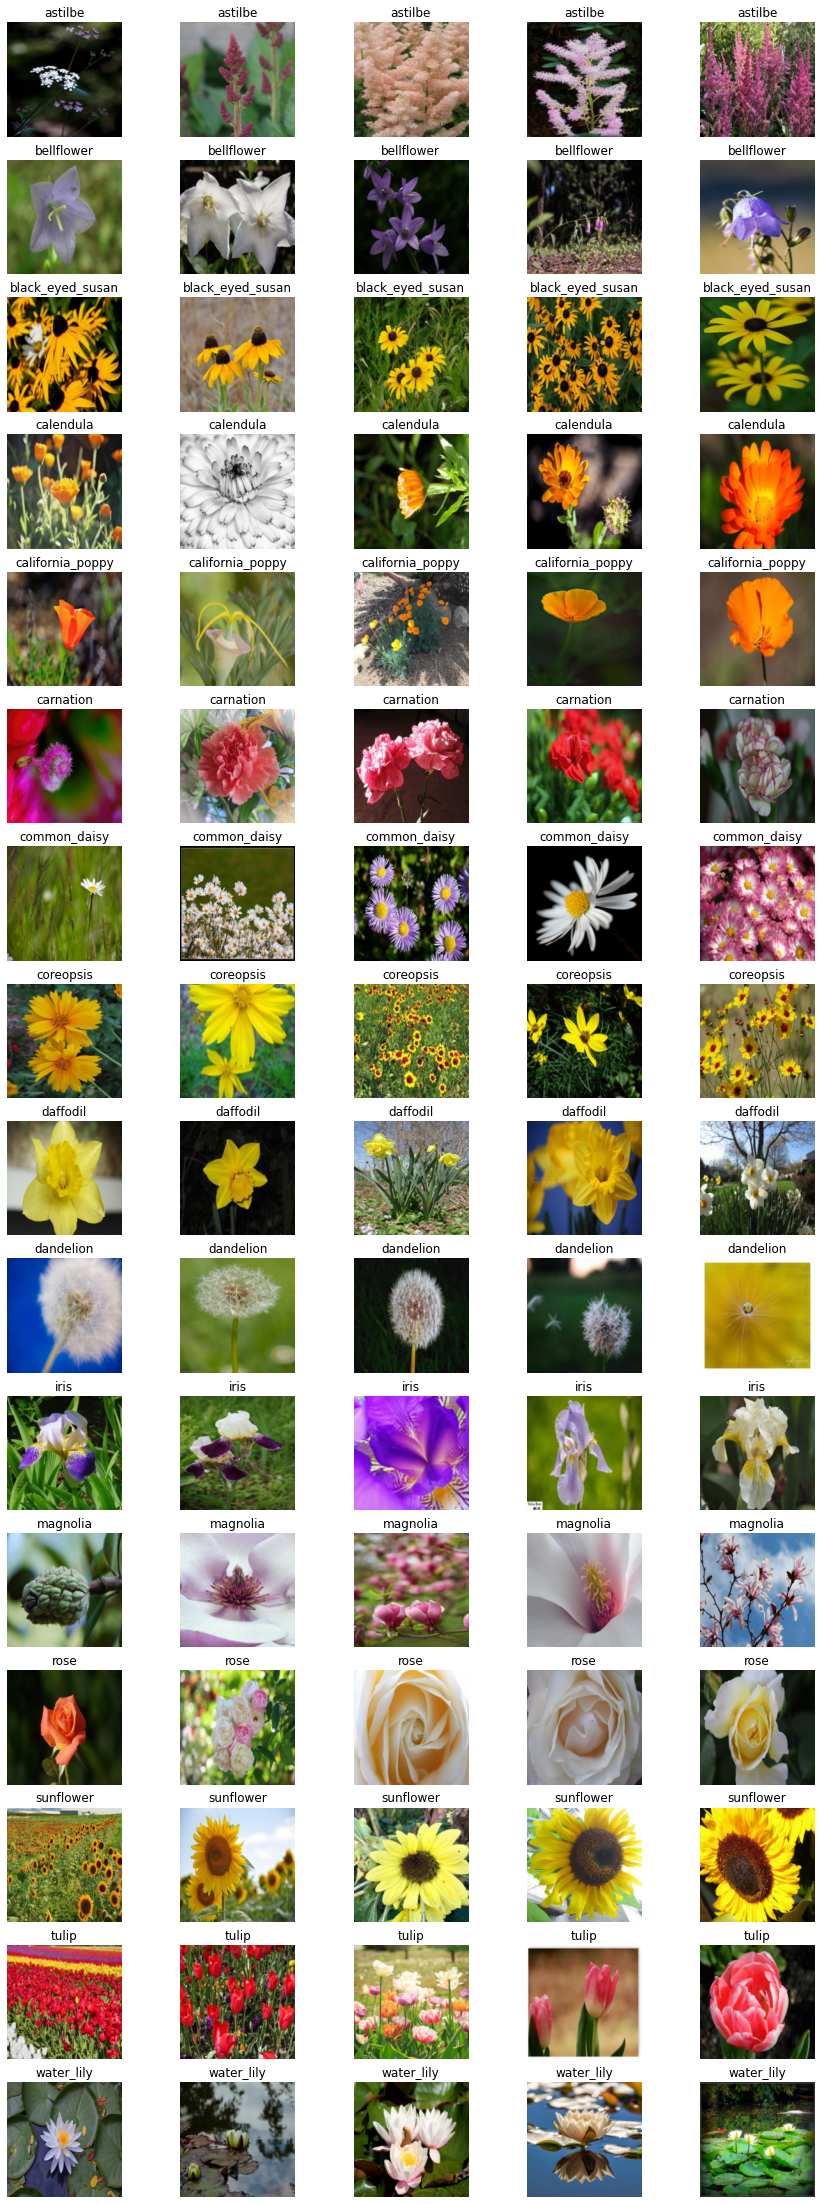

In [89]:
five_from_each_ds = Flowers(five_from_each)

figure = plt.figure(figsize=(15,40))
for i in range(1,len(five_from_each_ds)+1):
    img = five_from_each_ds[i-1][0].permute(1,2,0)
    label = class_labels[five_from_each_ds[i-1][1].item()]
    figure.add_subplot(16,5,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)